# Spam detector with Naive Bayes classifier

The setup below lets us:

*   import the general libreries that we are going to use,
*   download the raw dataset and separate the features from the label.





In [106]:
import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.metrics import ConfusionMatrix
from sklearn.model_selection import train_test_split
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Download dataset
path = kagglehub.dataset_download("balaka18/email-spam-classification-dataset-csv")

path = path + "/emails.csv"
#setup raw dataset
data = pd.read_csv(path)

#setup spam dataset for a visualization in the provenance part
spam = data.drop(data[data['Prediction'] == 0].index)
spam = spam.drop("Email No.", axis=1)
spam = spam.drop('Prediction', axis=1)

#split dataset and ground truths
X = data.drop('Prediction', axis=1)
#drop the email counter
X = X.drop("Email No.", axis=1)
y = data['Prediction']

confusion_matrixes = []
#0 = not spam | 1 = spam

I implement the classifier as a naive Bayes.

Unfortunately NLTK doesn't support cross validation directly, so I just iterate the split and train process 3 time (changing the random_state) in order to get a better estimate. This is not an actual cross validation process but is good enough, especially considering that the strenght of the solution is not the main interest of this project.

I fix the random_state at each iteration in order to get consistent results.

In [120]:
#we do 3 iteration in order to get a better estimate
for l in range(3):
  #split train and test
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=l)

  #setup train dataset for nltk naivebayes as a list of tuples (feature dictionary, label)
  train_data = []
  for i in range(len(X_train)):
      feature_dict = X_train.iloc[i].to_dict()
      train_data.append((feature_dict, y_train.iloc[i]))

  #train classifier
  classifier = NaiveBayesClassifier.train(train_data)

  #setup test dataset as seen for train dataset
  test_data = []
  for i in range(len(X_test)):
      feature_dict = X_test.iloc[i].to_dict()
      test_data.append((feature_dict, y_test.iloc[i]))

  predictions = []
  total_predictions = len(test_data)

  for features, _ in test_data:
      predictions.append(classifier.classify(features))

  #cast to have only list of strings in order to create the confusion matrix
  predictions = [str(label) for label in predictions]
  ground_truth = [str(label) for label in y_test]
  confusion_matrixes.append(ConfusionMatrix(ground_truth, predictions))

Here are the confusion matrixes for each iteration.

In [108]:
f_scores = []
for i in range(len(confusion_matrixes)):
  print(f"iteration number {i} \n")
  f_scores.append(confusion_matrixes[i].f_measure("1"))
  print(confusion_matrixes[i])
  print(confusion_matrixes[i].evaluate())
  print("\n \n")

f_score = np.average(f_scores)

iteration number 0 

  |   0   1 |
--+---------+
0 |<697> 53 |
1 |  97<188>|
--+---------+
(row = reference; col = test)

Tag | Prec.  | Recall | F-measure
----+--------+--------+-----------
  0 | 0.8778 | 0.9293 | 0.9028
  1 | 0.7801 | 0.6596 | 0.7148


 

iteration number 1 

  |   0   1 |
--+---------+
0 |<663> 56 |
1 |  82<234>|
--+---------+
(row = reference; col = test)

Tag | Prec.  | Recall | F-measure
----+--------+--------+-----------
  0 | 0.8899 | 0.9221 | 0.9057
  1 | 0.8069 | 0.7405 | 0.7723


 

iteration number 2 

  |   0   1 |
--+---------+
0 |<690> 50 |
1 |  93<202>|
--+---------+
(row = reference; col = test)

Tag | Prec.  | Recall | F-measure
----+--------+--------+-----------
  0 | 0.8812 | 0.9324 | 0.9061
  1 | 0.8016 | 0.6847 | 0.7386


 



In [109]:
count_spam = (data['Prediction'] == 1).sum()
print(f"There are {count_spam} spam emails over {data.shape[0]}")

There are 1500 spam emails over 5172


Since

1.   the objective is to identify most of spam emails while minimizing the number of non-spam emails marked as spam;

2.   the dataset is unbalanced (only 1500 spam emails over 5172 total);

the F-score (calculated on label 1) is the preferred metric to consider.

In [110]:
print(f_score)

0.7418933884268513


The current average F-score is pretty good considering the simple model implemented, let's see if it increases by adding provenance as a feature

# PROVENANCE


To determine the provenance a DBSCAN clustering approach is utilized, calculated on the cosine distance (1 - cosine similarity) as metric.
In this code it is implemented with sklearn.

In [112]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

cluster_X = StandardScaler().fit_transform(X)
#list of params in order to get a decent clustering
params = [
    {'eps': 0.2, 'min_samples': 5},
    {'eps': 0.2, 'min_samples': 10},
    {'eps': 0.2, 'min_samples': 15},
    {'eps': 0.2, 'min_samples': 20},
    {'eps': 0.3, 'min_samples': 5},
    {'eps': 0.3, 'min_samples': 10},
    {'eps': 0.3, 'min_samples': 15},
    {'eps': 0.3, 'min_samples': 20},
    {'eps': 0.4, 'min_samples': 5},
    {'eps': 0.4, 'min_samples': 10},
    {'eps': 0.4, 'min_samples': 15},
    {'eps': 0.4, 'min_samples': 20},
    {'eps': 0.5, 'min_samples': 5},
    {'eps': 0.5, 'min_samples': 10},
    {'eps': 0.5, 'min_samples': 15},
    {'eps': 0.5, 'min_samples': 20},
    {'eps': 0.6, 'min_samples': 5},
    {'eps': 0.6, 'min_samples': 10},
    {'eps': 0.6, 'min_samples': 15},
    {'eps': 0.6, 'min_samples': 20}
]

dbscan_results = {}
for param in params:
    dbscan = DBSCAN(eps=param['eps'], min_samples=param['min_samples'], metric='cosine')
    dbscan_labels = dbscan.fit_predict(cluster_X)

    #store the results
    dbscan_results[f"eps={param['eps']}, min_samples={param['min_samples']}"] = dbscan_labels

    #count the number of samples in each cluster
    unique_labels, counts = np.unique(dbscan_labels, return_counts=True)

    #print the count of samples in each cluster
    print(f"DBSCAN with eps={param['eps']}, min_samples={param['min_samples']}")
    for label, count in zip(unique_labels, counts):
        print(f"Cluster {label}: {count} samples")
    print("-" * 100)

#clustering = DBSCAN(eps=0.6, min_samples=5, metric='cosine')
#dbscan_labels = clustering.fit_predict(cluster_X)
#
#unique_labels, counts = np.unique(dbscan_labels, return_counts=True)
## Print the count of samples in each cluster
#for label, count in zip(unique_labels, counts):
#    print(f"Cluster {label}: {count} samples")
#print("-" * )


DBSCAN with eps=0.2, min_samples=5
Cluster -1: 4026 samples
Cluster 0: 45 samples
Cluster 1: 17 samples
Cluster 2: 17 samples
Cluster 3: 517 samples
Cluster 4: 11 samples
Cluster 5: 18 samples
Cluster 6: 8 samples
Cluster 7: 18 samples
Cluster 8: 5 samples
Cluster 9: 5 samples
Cluster 10: 17 samples
Cluster 11: 7 samples
Cluster 12: 5 samples
Cluster 13: 5 samples
Cluster 14: 5 samples
Cluster 15: 5 samples
Cluster 16: 7 samples
Cluster 17: 12 samples
Cluster 18: 16 samples
Cluster 19: 21 samples
Cluster 20: 5 samples
Cluster 21: 33 samples
Cluster 22: 7 samples
Cluster 23: 5 samples
Cluster 24: 6 samples
Cluster 25: 5 samples
Cluster 26: 12 samples
Cluster 27: 7 samples
Cluster 28: 6 samples
Cluster 29: 20 samples
Cluster 30: 5 samples
Cluster 31: 5 samples
Cluster 32: 55 samples
Cluster 33: 6 samples
Cluster 34: 15 samples
Cluster 35: 7 samples
Cluster 36: 5 samples
Cluster 37: 5 samples
Cluster 38: 23 samples
Cluster 39: 5 samples
Cluster 40: 7 samples
Cluster 41: 60 samples
Cluster

Considering the dataset presented, it is normal to have unbalanced clusters.

Below a visualization of the results of clustering using t-sne.

In [113]:
from sklearn.manifold import TSNE
#visualize the results with t-SNE
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(cluster_X)

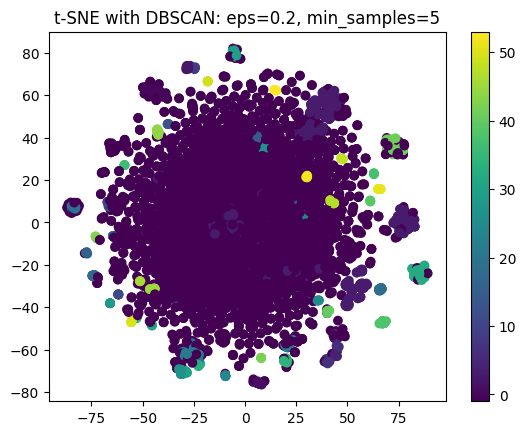

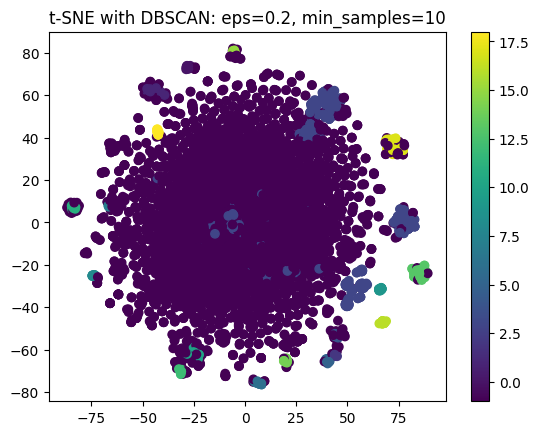

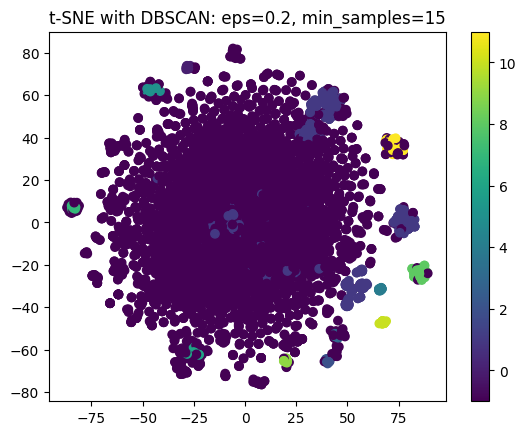

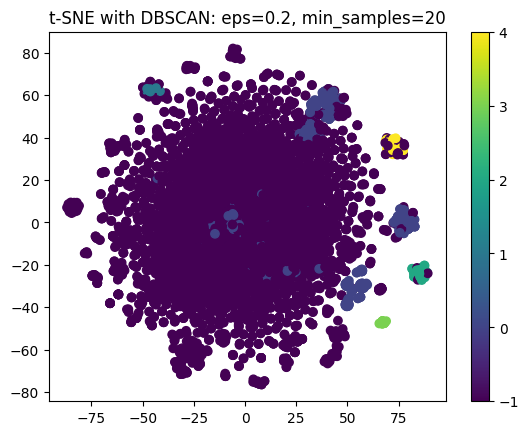

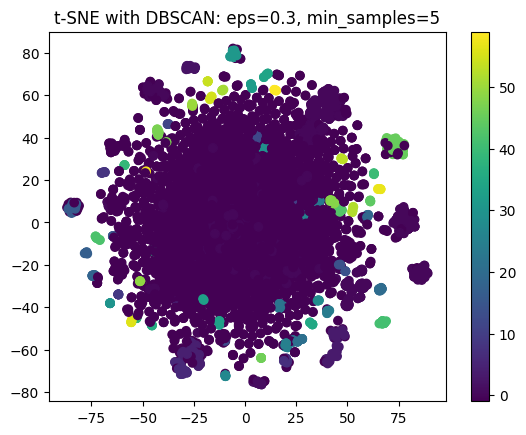

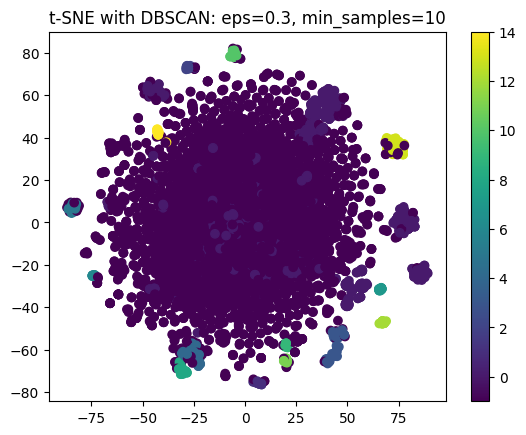

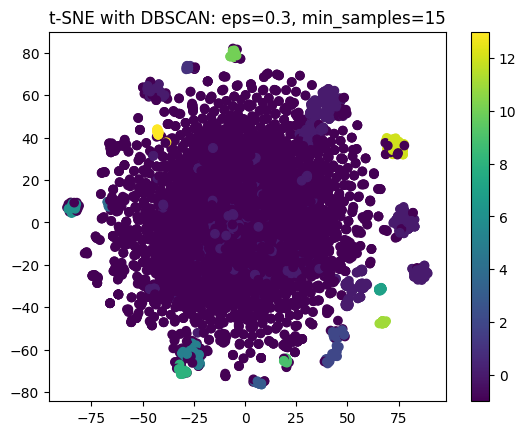

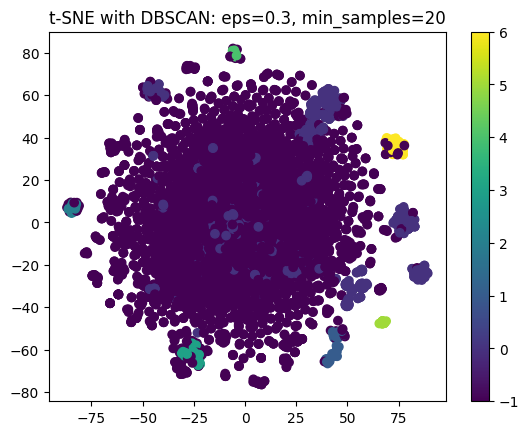

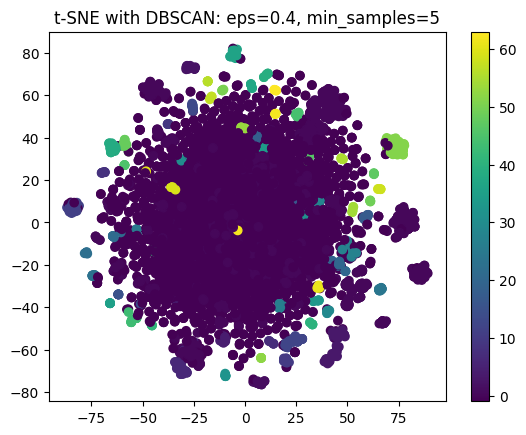

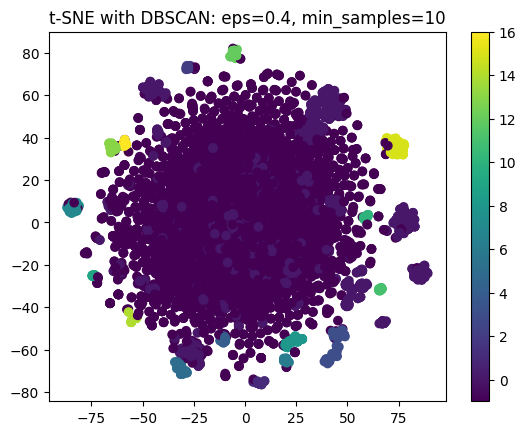

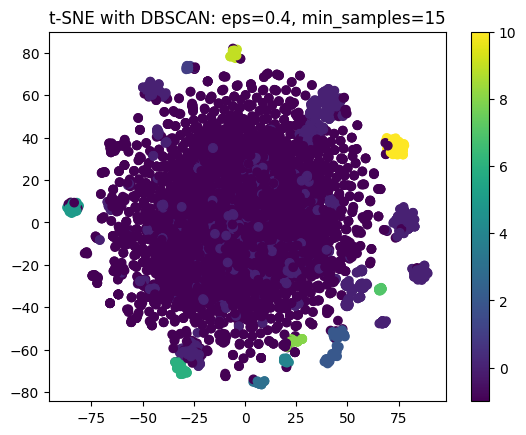

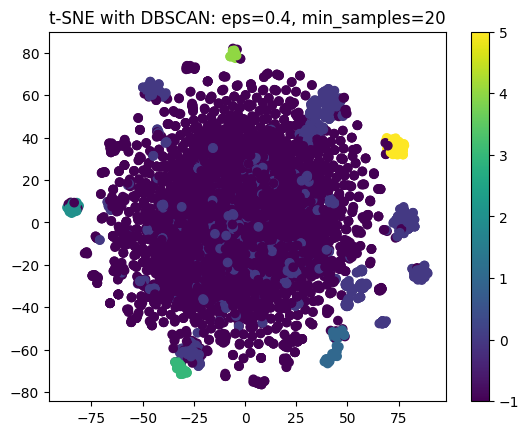

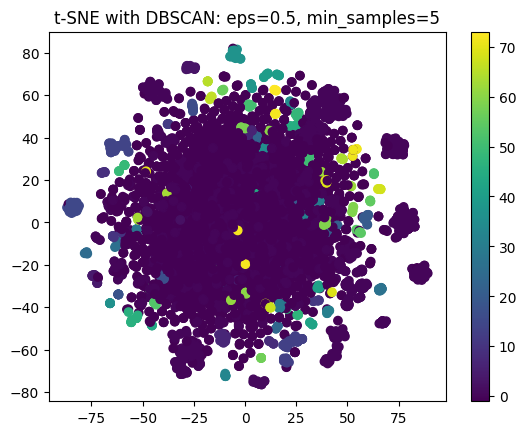

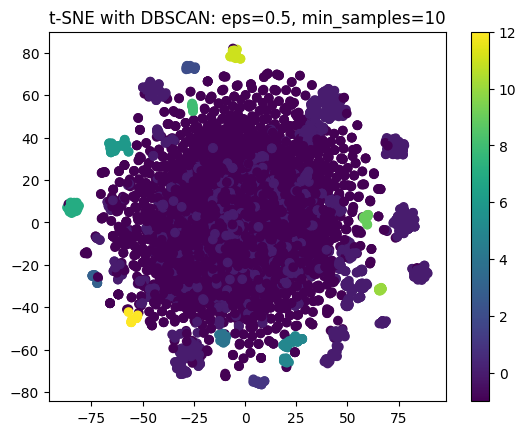

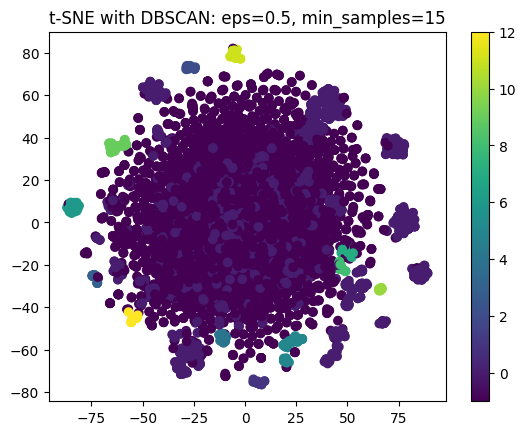

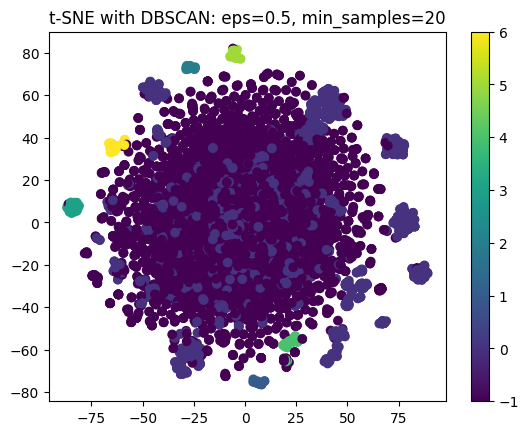

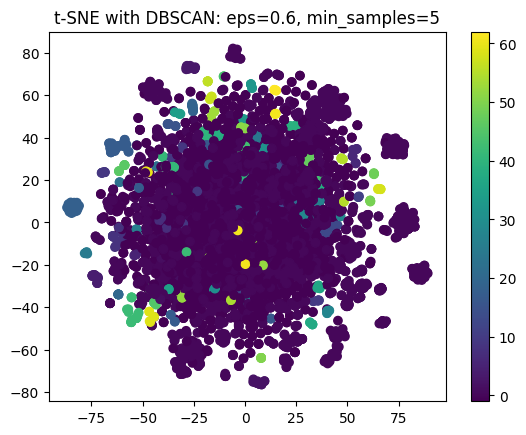

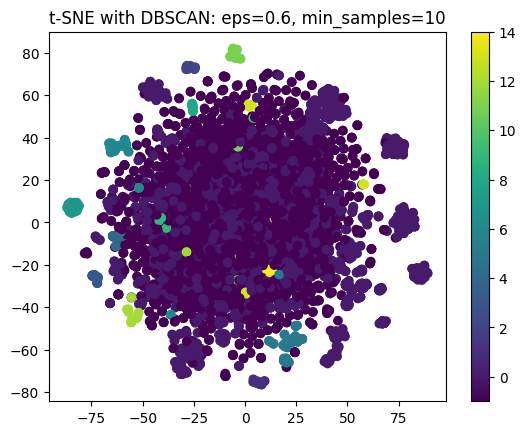

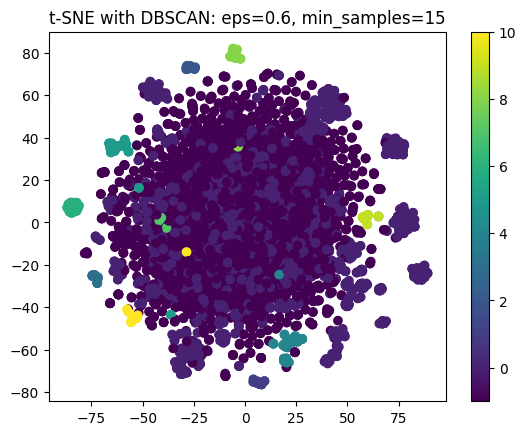

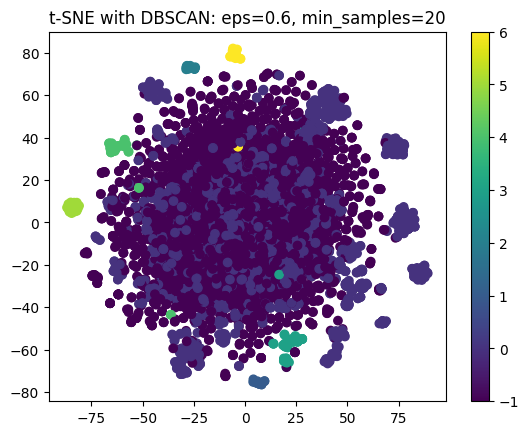

In [114]:
# Visualize each DBSCAN result
for param in params:
    dbscan_labels = dbscan_results[f"eps={param['eps']}, min_samples={param['min_samples']}"]
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=dbscan_labels, cmap='viridis')
    plt.title(f't-SNE with DBSCAN: eps={param["eps"]}, min_samples={param["min_samples"]}')
    plt.colorbar()
    plt.show()


A tsne look at  spam mails only in order to look for particular patterns.

In [115]:
#tsne only spam emails
spam = StandardScaler().fit_transform(spam)
spam_tsne = TSNE(n_components=2, random_state=42).fit_transform(spam)

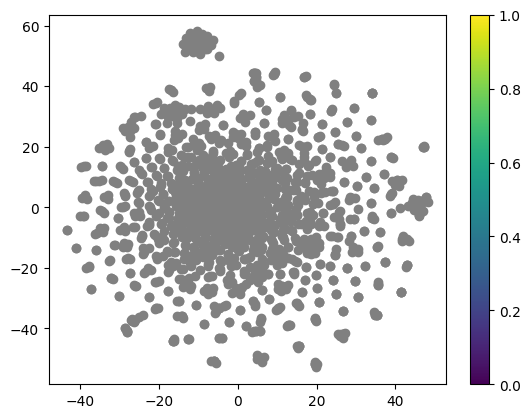

In [116]:
plt.scatter(spam_tsne[:, 0], spam_tsne[:, 1], c="grey")
plt.colorbar()
plt.show()

Since there are no particular pattern in the spam email, the best parameters for clusterization are selected based only on the clusters.

The selected parameters are: epsilon = 0.3, min_samples = 20. There are a total of 8 clusters, ranging from -1 to 6.

A naive bayes model is now built considering only the provenance:

In [121]:
clusters = (dbscan_results[f"eps={0.3}, min_samples={20}"])
df = pd.DataFrame(clusters, columns=['cluster'])
cm_clusters = []
#we do 3 iteration in order to get a better estimate
for l in range(3):
  #split train and test
  cluster_train, cluster_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=l)

  #setup train dataset for nltk naivebayes as a list of tuples (feature dictionary, label)
  train_data = []
  for i in range(len(cluster_train)):
      feature_dict = cluster_train.iloc[i].to_dict()
      train_data.append((feature_dict, y_train.iloc[i]))

  #train classifier
  provenance_classifier = NaiveBayesClassifier.train(train_data)

  #setup test dataset as seen for train dataset
  test_data = []
  for i in range(len(cluster_test)):
      feature_dict = cluster_test.iloc[i].to_dict()
      test_data.append((feature_dict, y_test.iloc[i]))

  cluster_predictions = []
  total_predictions = len(test_data)

  for features, _ in test_data:
      cluster_predictions.append(provenance_classifier.classify(features))

  #cast to have only list of strings in order to create the confusion matrix
  cluster_predictions = [str(label) for label in cluster_predictions]
  ground_truth = [str(label) for label in y_test]
  cm_clusters.append(ConfusionMatrix(ground_truth, cluster_predictions))

In [122]:
for i in range(len(cm_clusters)):
  print(f"iteration number {i} \n")
  print(cm_clusters[i])
  print(cm_clusters[i].evaluate())
  print("\n \n")


iteration number 0 

  |   0   1 |
--+---------+
0 |<750>  . |
1 | 281  <4>|
--+---------+
(row = reference; col = test)

Tag | Prec.  | Recall | F-measure
----+--------+--------+-----------
  0 | 0.7274 | 1.0000 | 0.8422
  1 | 1.0000 | 0.0140 | 0.0277


 

iteration number 1 

  |   0   1 |
--+---------+
0 |<719>  . |
1 | 309  <7>|
--+---------+
(row = reference; col = test)

Tag | Prec.  | Recall | F-measure
----+--------+--------+-----------
  0 | 0.6994 | 1.0000 | 0.8231
  1 | 1.0000 | 0.0222 | 0.0433


 

iteration number 2 

  |   0   1 |
--+---------+
0 |<740>  . |
1 | 286  <9>|
--+---------+
(row = reference; col = test)

Tag | Prec.  | Recall | F-measure
----+--------+--------+-----------
  0 | 0.7212 | 1.0000 | 0.8381
  1 | 1.0000 | 0.0305 | 0.0592


 



It is easy to see that the model never consider a non-spam email as spam, but is not able to correctly predict the spam emails.

Now the models are combined, if the cluster_model predicts that a mail is spam the combined model will consider it as spam with no regards to the initial classifier (it's a logical or on the predictions).

The example below utilize the last split utilized (l = 3)

In [144]:
final_predictions = ['1' if v1 == '1' or v2 == '1' else '0' for v1, v2 in zip(predictions, cluster_predictions)]
final_cm = ConfusionMatrix(ground_truth, final_predictions)

print("CM considering clusters")
print(final_cm)
print(final_cm.evaluate())
print("-" * 100)
print("CM without clusters")
print(confusion_matrixes[2])
print(confusion_matrixes[2].evaluate())

CM considering clusters
  |   0   1 |
--+---------+
0 |<690> 50 |
1 |  93<202>|
--+---------+
(row = reference; col = test)

Tag | Prec.  | Recall | F-measure
----+--------+--------+-----------
  0 | 0.8812 | 0.9324 | 0.9061
  1 | 0.8016 | 0.6847 | 0.7386

----------------------------------------------------------------------------------------------------
CM without clusters
  |   0   1 |
--+---------+
0 |<690> 50 |
1 |  93<202>|
--+---------+
(row = reference; col = test)

Tag | Prec.  | Recall | F-measure
----+--------+--------+-----------
  0 | 0.8812 | 0.9324 | 0.9061
  1 | 0.8016 | 0.6847 | 0.7386



The logical or on the prediction does not modify the F-score in this split, probably because the number of email marked as spam is really low for the cluster method.

In order to improve this procedure and seeing a higher F-score, better clusters (Provenance) are necessary.